# LightGBM

In this notebook, I will explore the performance of LightGBM. It is rapidly gaining popularity, especially amongst the Kagglers. Its prediction accuracy is on par with XGBoost, but runs faster (in my experience, almost twice faster!). Thus, it allows one to experiment with more setups.

I will compare LightGBM with a Random Forest Classifier model from the previous section. As a bonus, I will also compare the result of a RandomizedSearchCV result with a Python implementation of a genetic algorithm, EvolutionaryAlgorithmSearchCV.

In [1]:
# For general dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
%matplotlib inline

#For model evaluation metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report,  confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold

#For models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, RandomizedLogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings('ignore')

/home/mike/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def display_result(X_train, X_test, y_train, y_test, clf, display_roc=True):
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print (classification_report(y_test, y_pred))


    matrix = pd.DataFrame(
           confusion_matrix(y_test,y_pred),
            columns=['Predicted False', 'Predict True'],
            index = ['Actual False', 'Actual True'])
    display(matrix)
    
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    if display_roc:
        
        plt.plot(fpr, tpr,label='%s (area = %0.2f)' % ('LogisticRegression', roc_auc_score(y_test, y_pred)))
        # Plot Base Rate ROC
        plt.plot([0,1], [0,1],label='Base Rate' 'k--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Graph')
        plt.legend(loc="lower right")
        plt.show()
        return
    return fpr, tpr, thresholds, y_pred

def read_data(onehot=False, label=False, return_cat_columns=False):
    df = pd.read_csv('churn.csv')
    df.columns = df.columns.str.lower().str.replace(' ','_')
    df.rename(columns={'churn?':'churn', "int'l_plan":'intl_plan'}, inplace=True)
    df = (df.drop(['phone','day_charge','eve_charge','night_charge','intl_charge'], axis=1)
            .replace(['True.','False.'],[1,0]))
    df.area_code = df.area_code.astype('object')
    if label:
        df = df.replace(['yes','no'],[1,0])
    if onehot:
        df = pd.get_dummies(df, columns=['state','area_code'], drop_first=True)
    if return_cat_columns:
        return df, df.dtypes[df.dtypes==object].index.values.tolist()
    else:
        return df

In [3]:
df = read_data(label=True)
df.drop(['state','area_code'],axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df.drop('churn', axis=1), df.churn.values, test_size=0.2,
                                                   random_state=0)

In [4]:
scaler = StandardScaler()
x_train = X_train.copy()
x_test = X_test.copy()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#cv = KFold(n_splits=5, shuffle=True, random_state=0)

os_us = SMOTETomek(ratio=0.5, k=5)
X_train_res, y_train_res = os_us.fit_sample(x_train, y_train)

/home/mike/anaconda/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/mike/anaconda/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


## Benchmark Model

In [5]:
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV
from sklearn.cross_validation import KFold

             precision    recall  f1-score   support

          0       0.98      0.96      0.97       579
          1       0.76      0.84      0.80        88

avg / total       0.95      0.94      0.94       667



,Predicted False,Predict True
Actual False,555,24
Actual True,14,74


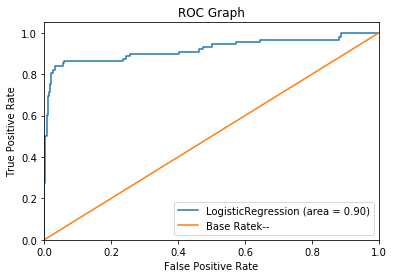

In [6]:
clf_base =  RandomForestClassifier()

grid = {
    'n_estimators': [10,20,50,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    "max_features": [3, 5],
    "max_depth" : [5,6,7,8,9,10],
    "min_samples_split" : [2, 4] ,
}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf_rf_smote = GridSearchCV(clf_base, grid, cv=cv, n_jobs=-1, scoring='f1_weighted')

display_result(X_train_res, x_test, y_train_res, y_test, clf_rf_smote)

## LightGBM

**1. LightGBM without tuning**

             precision    recall  f1-score   support

          0       0.97      0.95      0.96       579
          1       0.70      0.83      0.76        88

avg / total       0.94      0.93      0.93       667



,Predicted False,Predict True
Actual False,548,31
Actual True,15,73


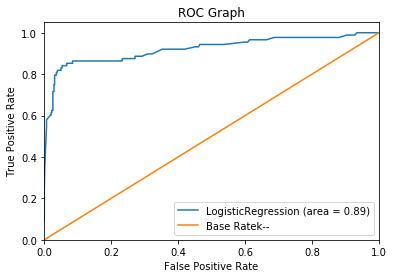

In [7]:
from lightgbm import LGBMClassifier

gbm = LGBMClassifier(objective='binary', 
                          n_jobs=-1, 
                          random_state=0,
                          subsample=1.0)
display_result(X_train_res, x_test, y_train_res, y_test, gbm)

** 2. Tuning LightGBm using RandomizedSearchCV**

In [56]:
param_grid = {
    'learning_rate': [0.01, 0.05,0.1, 0.005,0.001],
    'n_estimators': [500,600,700,800],
    'num_leaves': [35,40,45,50],
    'max_depth': [8,10,12,14],
    'max_bin':[255,280,300,320,350,400],
    'colsample_bytree' : [0.5,0.7,0.9],
    'subsample' : [0.7,0.8,0.9,1],
    'min_child_samples':[12,15,20,25,30,40],
    'min_child_weight':[1,2,3,4,5,7]
}

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  9.7min finished


             precision    recall  f1-score   support

          0       0.98      0.98      0.98       579
          1       0.86      0.84      0.85        88

avg / total       0.96      0.96      0.96       667



,Predicted False,Predict True
Actual False,567,12
Actual True,14,74


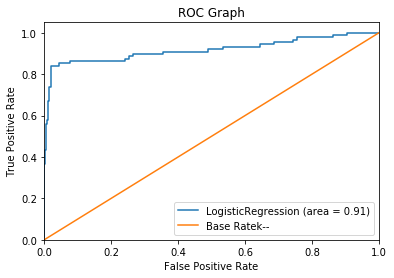

In [57]:
clf_lgb_smote = RandomizedSearchCV(LGBMClassifier(objective='binary',
                                                  boosting_type='gbdt',
                                                  reg_alpha=0.1,
                                                  reg_lambda=0,
                                                  n_jobs=-1, 
                                                  seed=0),
                                   param_distributions=param_grid, 
                                   cv=cv, n_jobs=-1,
                                   n_iter=50,
                                   verbose=1,
                                   scoring='f1_weighted')

display_result(X_train_res, x_test, y_train_res, y_test, clf_lgb_smote)

In [58]:
clf_lgb_smote.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.7, learning_rate=0.1,
        max_bin=400, max_depth=12, min_child_samples=20,
        min_child_weight=1, min_split_gain=0.0, n_estimators=700,
        n_jobs=-1, num_leaves=50, objective='binary', random_state=0,
        reg_alpha=0.1, reg_lambda=0, seed=0, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

** 3. Tuning LightGBM using EvolutionaryAlgorithmSearchCV**

Types [2, 1, 1, 1, 2, 2, 1, 1] and maxint [4, 3, 3, 3, 2, 3, 5, 5] detected
--- Evolve in 138240 possible combinations ---
gen	nevals	avg     	min     	max     	std     
0  	100   	0.943475	0.899987	0.960836	0.015404
1  	75    	0.956026	0.939527	0.96201 	0.0036133
2  	55    	0.959119	0.95425 	0.962018	0.00150121
3  	61    	0.960138	0.955782	0.963241	0.00144648
4  	55    	0.961029	0.94145 	0.963241	0.00253532
5  	59    	0.961816	0.94263 	0.963488	0.00233936
6  	47    	0.96255 	0.954949	0.963488	0.00120854
7  	63    	0.962319	0.927286	0.963488	0.00394495
8  	53    	0.962837	0.956112	0.963488	0.00130012
9  	53    	0.96261 	0.927286	0.963488	0.00375399
10 	57    	0.96246 	0.925289	0.963781	0.00553025
11 	55    	0.962885	0.942657	0.963781	0.00238293
12 	60    	0.963043	0.951705	0.963781	0.00168435
13 	55    	0.963562	0.95684 	0.963781	0.000752954
14 	52    	0.963583	0.956112	0.963781	0.00112787 
15 	61    	0.963192	0.92533 	0.963781	0.0038731  
16 	59    	0.963725	0.960849	0.96379 	0.000392

,Predicted False,Predict True
Actual False,563,16
Actual True,14,74


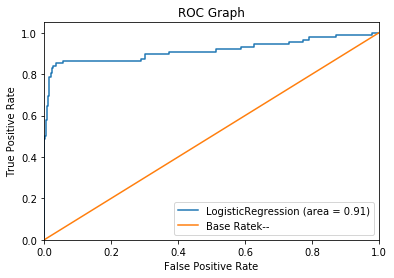

In [55]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV
clf_lgb_evo = EvolutionaryAlgorithmSearchCV(estimator=LGBMClassifier(objective='binary',
                                                  boosting_type='gbdt',
                                                  reg_alpha=0.1,
                                                  reg_lambda=0,
                                                  n_jobs=-1, 
                                                  seed=0),
                                   params=param_grid,
                                   scoring="f1_weighted",
                                   cv=cv,
                                   verbose=1,
                                   population_size=100,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=5,
                                   generations_number=30,
                                   n_jobs=4)

display_result(X_train_res, x_test, y_train_res, y_test, clf_lgb_evo)

The result from the RandomizedSearchCV is slightly better (maynot be significant) than the one getting from the EvolutionaryAlgorithmSearchCV. It tooks several runs (with adjustment on parameters) of RandomizedSearchCV to get the above result, but with smaller batches, I ended up arrive at the result sooner than the EvolutionaryAlgorithmSearchCV, which took more than two hours to run on a laptop with an intel i7 4600mq and 16GB of RAM.